In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [102]:
dl = LFWDataLoader(batch_size=24)

train_dl = dl.train_dataloader
val_dl = dl.val_dataloader
test_dl = dl.test_dataloader

torch.Size([24, 3, 64, 64])
torch.Size([24, 3, 64, 64])


C:\Users\rwbak\AppData\Local\Temp\ipykernel_34140\3678062090.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 20000 + 1) instead
  random = np.random.random_integers(0,20000)


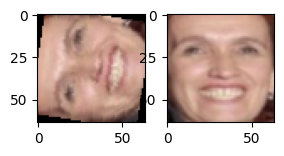

In [103]:
f = plt.figure()
random = np.random.random_integers(0,20000)
data, label = next(iter(train_dl))
print(data.shape)
print(label.shape)
f.add_subplot(2,4,1)
plt.imshow(data[0].to('cpu').permute(1, 2, 0))
f.add_subplot(2,4,2)
plt.imshow(label[0].to('cpu').permute(1, 2, 0))

In [147]:
from model import *
from loss import LogCoshLoss, PerceptualLoss

latent = 100
hidden = 100

model = AutoEncoder(NewEncoder(latent),NewDecoder(latent))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optim = torch.optim.Adagrad(model.to(device).parameters(),lr=1e-3,weight_decay=0.97)

trainer = Trainer(model, optim, device, train_dl, val_dl,kl_factor=1,kl_rate=1,kl_max=1, lossfn=nn.BCELoss(reduction='sum'))
torch.cuda.empty_cache()
mse, kl, total = trainer.train_model(epochs=100,print_every=100)

36806731
EPOCH:  0
Iteration 0, loss = 205026.4219
KL Factor: 1.000000
KL 0.2790
Avg Loss on Val: 0.04741436243057251

Iteration 100, loss = 195457.8906
KL Factor: 1.000000
KL 22.4713
Avg Loss on Val: 0.03037628105708531

Iteration 200, loss = 191315.5156
KL Factor: 1.000000
KL 97.8321
Avg Loss on Val: 0.028241253324917386

Iteration 300, loss = 192027.3281
KL Factor: 1.000000
KL 180.7356
Avg Loss on Val: 0.022840316806520735

Iteration 400, loss = 191765.0938
KL Factor: 1.000000
KL 235.0347
Avg Loss on Val: 0.022093338625771657

EPOCH:  1
Iteration 0, loss = 191342.3438
KL Factor: 1.000000
KL 365.5091
Avg Loss on Val: 0.020929368478911265

Iteration 100, loss = 190908.5781
KL Factor: 1.000000
KL 270.9512
Avg Loss on Val: 0.019967215401785716

Iteration 200, loss = 188492.3281
KL Factor: 1.000000
KL 289.9843
Avg Loss on Val: 0.01965688169002533

Iteration 300, loss = 188731.9375
KL Factor: 1.000000
KL 376.9121
Avg Loss on Val: 0.01821572014263698

Iteration 400, loss = 188233.0000
KL F

In [148]:
trainer.check_accuracy(loader=test_dl,model=model)

Avg Loss on Val: 0.007479206259761538


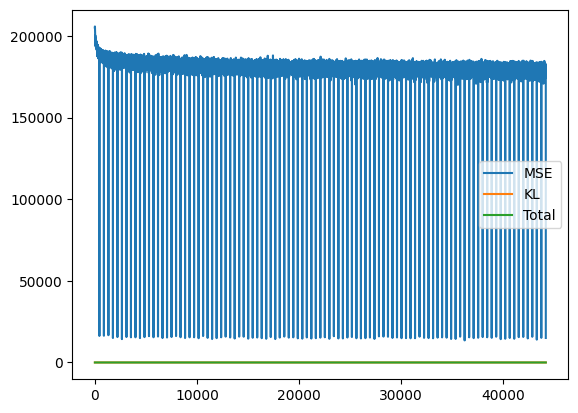

In [149]:
total = np.minimum(total,0.25)
kl = np.minimum(kl,0.25)

plt.plot(range(len(mse)),mse,label='MSE')
plt.plot(range(len(kl)),kl,label='KL')
plt.plot(range(len(total)),total,label='Total')
plt.legend()

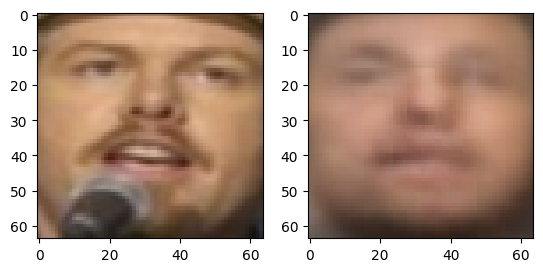

In [150]:
f = plt.figure()
tensor_image,_ = next(iter(test_dl))
f.add_subplot(1,2,1)
plt.imshow(tensor_image[0].permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image[0].unsqueeze(0)
    scores,_ = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

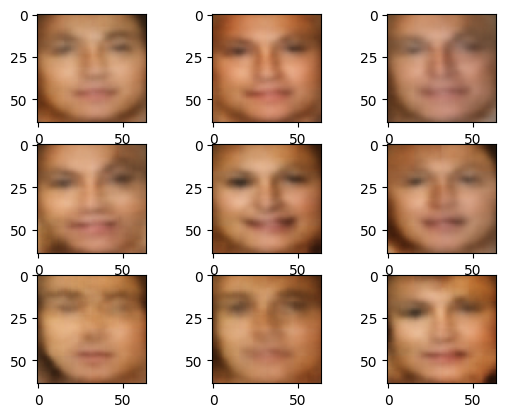

In [151]:
encoder = model.encoder
decoder = model.decoder
idx = np.random.randint(0,1000)
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(latent_mu,3*np.exp(0.5*latent_var),(9,latent)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

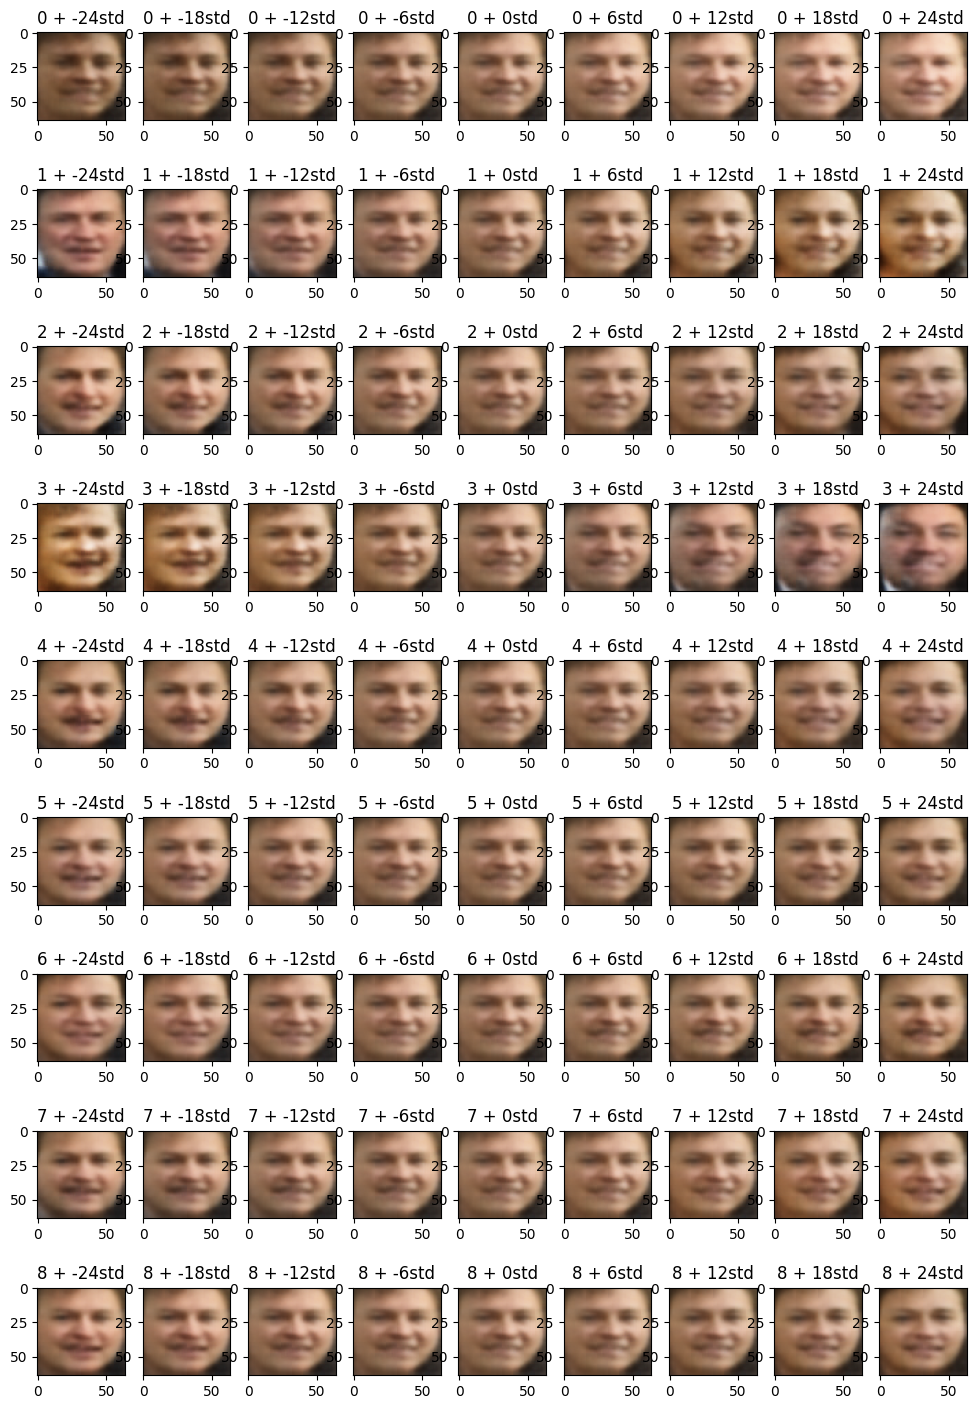

In [152]:
encoder = model.encoder
decoder = model.decoder

num_latents = 9
latent_offset = 0
f = plt.figure(figsize=(12,18))

# Get latent space of random image
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()

#Get different num standard deviations from mu
add = torch.arange(-4,5)*6

#for each of N latent spaces iterate thru stdevs
for latent_i in range(num_latents):
    for i in range(9):
        #generate new faces with each stdev
        randomData = latent_mu.clone().detach()
        with torch.no_grad():
            randomData[0][latent_i + latent_offset] = latent_mu[0][latent_i + latent_offset] + add[i] * torch.exp(0.5*latent_var[0][latent_i + latent_offset])
            scores = model.decoder(randomData.to(device))
        #plot it
        f.add_subplot(num_latents,9,(9*latent_i) + i+1)
        plt.imshow(scores[0].squeeze(0).to('cpu').permute(1, 2, 0))
        plt.title('{} + {}std'.format(latent_i + latent_offset,add[i]))

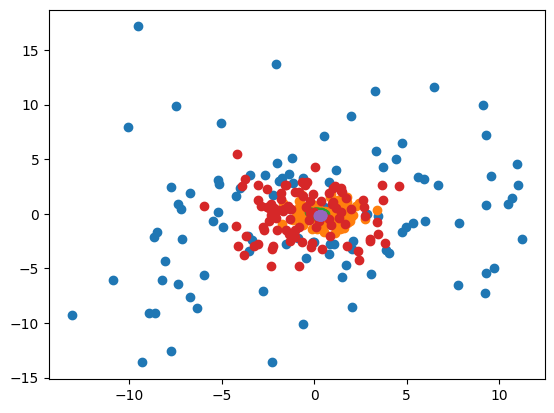

In [153]:
encoder = model.encoder
tensor_image,_ = next(iter(test_dl))
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
for i in range(5):
    latent_dist = torch.distributions.Normal(latent_mu[0,i],torch.abs(latent_var[0,i]))
    latent_dist_2 = torch.distributions.Normal(latent_mu[1,i],torch.abs(latent_var[1,i]))
    # plt.scatter(np.abs(latent_var[:,i]),np.abs(latent_var[:,i+1]))
    plot1,plot2 = [],[]
    for i in range(100):
        plot1.append(latent_dist.rsample())
        plot2.append(latent_dist_2.rsample())
    plt.scatter(plot1,plot2)

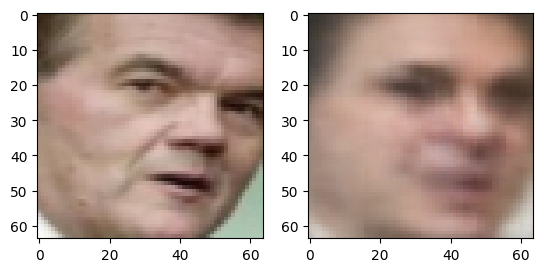

In [195]:
torch.save(model,'100_epoch')

In [113]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()